# **TCC - Recomendação de Cosméticos para Tratamento de Pele**
## Desenvolvido por: Lucas Rafael Hara Motta
## PUC - Minas
## Especialização em Inteligência Artificial e Machine Learning

# Tratamento Inicial dos Dados e Análise Explorativa dos Dados (EDA)

### Importação das bibliotecas

In [55]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

## Análise e tratamento inicial dos dados

In [56]:
df = pd.read_csv("Products Info.csv", sep='|')
df.sample(2)

,Brand,Name,Category,Rating,Price,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Finish,Product Type,Benefits,Coverage,Fragrance Family,Hair Type,Hair Concerns
637,ALPHA-H,Balancing Moisturiser & Gentle Exfoliant with ...,Moisturiser,3.7,RM267.00,"Combination, Normal, Oily","Ageing, Dryness, Fine Lines & Wrinkles, Oiline...",Cream,"20s, 30s, 40s, 50+, Under 20","Aqua, Glycolic Acid, Aloe Barbadensis Leaf Jui...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,LA MER,Mosturizing Soft Cream Duo (Limited Edition),Moisturiser,NaN,"RM1,460.00","Combination, Dry, Normal, Oily","Dryness, Dullness",Cream,"20s, 30s, 40s, 50+, Under 20",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931 entries, 0 to 1930
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand             1931 non-null   object 
 1   Name              1931 non-null   object 
 2   Category          1931 non-null   object 
 3   Rating            1708 non-null   float64
 4   Price             1931 non-null   object 
 5   Skin Type         1834 non-null   object 
 6   Skin Concerns     1878 non-null   object 
 7   Formulation       1589 non-null   object 
 8   Skincare By Age   1906 non-null   object 
 9   Ingredients       1543 non-null   object 
 10  Function          699 non-null    object 
 11  Finish            56 non-null     object 
 12  Product Type      15 non-null     object 
 13  Benefits          116 non-null    object 
 14  Coverage          3 non-null      object 
 15  Fragrance Family  1 non-null      object 
 16  Hair Type         3 non-null      object 


In [58]:
fig = px.bar(df.aggregate('count'),
       title="Quantidade de valores não-nulos por coluna",
       labels={'value':'Qtd. de valores', 'index':'Coluna', 'variable':'Contagem'},
       width=1100,
       text_auto=True)

fig.update_layout(showlegend=False)
fig.show()


### Exclusão de colunas

As colunas de 0 a 9 foram esperadas. Contudo, as colunas de 10 a 17 apareceram para alguns dos produtos analisados.  
As colunas de 11 a 17 possuem muitos dados nulos, portanto serão desconsideradas.  
A coluna 10, apesar de possuir vários valores faltantes (aprox. 64%), pode ser de alguma relevância para o modelo.

In [59]:
df.drop(df.columns[11:], axis=1, inplace=True)

### Brand e Name

Para facilitar a visualização e a posterior recomendação será concatenado as colunas de Brand e Name.

In [60]:
df['Full Name'] = df['Brand'] + " | " + df['Name']
df.head(2)

,Brand,Name,Category,Rating,Price,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Full Name
0,ORIGINS,GinZing™ & Mega-Mushroom Hydrating Glow Kit,Cleanser And Exfoliator,4.7,RM139.00,"Combination, Dry, Normal, Oily","Dryness, Dullness, Uneven Skin Texture","Cream, Gel, Liquid, Lotion","20s, 30s, 40s, 50+, Under 20",Ginzing™ Refreshing Scrub Cleanser: Water\Aqua...,NaN,ORIGINS | GinZing™ & Mega-Mushroom Hydrating G...
1,FRESH,Soy Face Cleanser,Cleanser And Exfoliator,4.4,RM180.00,"Combination, Dry, Normal, Oily, Sensitive","Ageing, Dryness, Dullness, Firmness & Elasticity",Cream,"30s, 40s, 50+","Aqua (Water), Coco-Glucoside, Glycerin, Butyle...",NaN,FRESH | Soy Face Cleanser


### Price

Como a fonte de dados foi do site Sephora Malaysia, a moeda utilizada para os produtos é o Ringgit malaio.  
Para facilitar a utilização dos dados, a coluna preço será convertida para dólares americanos.  
A conversão utilizada será com base no dia 12/02/2022, onde 1 USD (dólar americano) equivale a 4,19 RM (ringgit malaio).

In [61]:
def convert_price(price):
    # Exemplo de preço : 'RM1,450.00(20% OFF)'

    usd_to_rm = 4.19

    conv_price = price.replace(",", "")
    conv_price = conv_price.split("RM")[-1]
    conv_price = conv_price.split("(")[0]
    conv_price = float(conv_price)/(usd_to_rm)
    conv_price = f"U$ {conv_price:.2f}"

    return conv_price

In [62]:
df['Price'] = df['Price'].apply(lambda x: convert_price(x))

### Skin Type, Skin Concerns, Formulation, Skincare By Age

Essas colunas são compostas por vários valores.  
Portanto, os valores serão transformados em uma lista.  
Os valores nulos serão substituídos por uma string vazia ("").

In [63]:
for col in ['Skin Type', 'Skin Concerns', 'Formulation', 'Skincare By Age']:
    df[col] = df[col].fillna("")
    df[col] = df[col].apply(lambda x: x.split(', '))

Verificação se existem erros de grafia ou outras inconsistência nos valores.

In [64]:
for col in ['Skin Type', 'Skin Concerns', 'Formulation', 'Skincare By Age']:

    itens = []

    for value in df[col]:
        valids = [v for v in value if v not in itens]
        itens += valids
    
    itens.sort()

    print("Coluna: ", col)
    print(itens, '\n')

Coluna:  Skin Type
['', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'] 

Coluna:  Skin Concerns
['', 'Ageing', 'Blackheads', 'Blemishes', 'Dark Circles', 'Dryness', 'Dullness', 'Fine Lines & Wrinkles', 'Firmness & Elasticity', 'Oiliness', 'Pigmentation & Dark Spots', 'Puffiness', 'Uneven Skin Texture', 'Uneven Skin Tone', 'Visible Pores'] 

Coluna:  Formulation
['', 'Balm', 'Bar', 'Charcoal', 'Clay/Mud', 'Cream', 'Foam', 'Gel', 'Liquid', 'Loose Powder', 'Lotion', 'Mousse', 'Oil', 'Peel', 'Powder', 'Pressed Powder', 'Serum', 'Sheet', 'Spray', 'Stick', 'Wash-Off', 'Wipe'] 

Coluna:  Skincare By Age
['', '20s', '30s', '40s', '50+', 'Under 20'] 



### Ingredients

Como a premissa do algoritmo é identificar produtos similares utilizando os ingredientes, todos os produtos que não possuírem ingredientes serão excluídos do dataset.

In [65]:
df = df.dropna(subset=['Ingredients'])

Os ingredientes estão agrupados e também serão transformados em uma lista de valores.  
A diferença é que existem produtos que são 'kits' ou possuem mais de tipo na hora da compra.  
Nesses produtos, os ingredientes são listados categorizados por cada item do kit.

- Exemplo de produto individual:

        Nome: GinZing™ Refreshing Scrub Cleanser
        Ingredientes:
            Water, Cocamidopropyl Hydroxysultaine, Coco-Betaine, Sodium Lauroyl Oat Amino Acids, etc.

- Exemplo de produto em kit ou com mais de uma opção:

        Nome: Colorful Vitamin Face Mask
        Opções: Dragonfruit Vitamin Mask / Papaya Vitamin Mask
        Ingredientes:
            Dragonfruit Vitamin Mask
            Ingredients : Aqua (Water), Butylene Glycol, Glycerin, Aloe Barbadensis Leaf Juice, etc.

            Papaya Vitamin Mask
            Ingredients : Aqua (Water), Butylene Glycol, Glycerin, Polyglyceryl-10 Laurate, etc.

Como premissa, será adotado que o algoritmo irá buscar apenas produtos singulares para recomendação.  
Dessa forma, os kits serão desconsiderados.  
A princípio, isso será feito identificando se existe o sinal ":" no campo de ingredientes.  

In [66]:
# Remove os produtos com ':' no campo 'Ingredients'
df = df[df['Ingredients'].map(
    lambda x: (":" not in x) and ("：" not in x)
)]

# Troca os caracteres de separação por "," e coloca o texto em letras minúsculas
df['Ingredients'] = df['Ingredients'].map(
    lambda x: x.replace(", ", ",").replace(" ,", ",").replace("、", ",").replace("|", ",").replace("•", ",").lower()
    )

# Separa os ingredientes em uma lista
df['Ingredients'] = df['Ingredients'].map(lambda x: x.split(","))

In [67]:
itens = []

for value in df['Ingredients']:
    valids = [v for v in value if v not in itens]
    itens += valids

itens.sort()
print(len(itens))
for item in itens:
    print(item)

4831

 acetyl glucosamine 
 acrylamide/sodium acryloyldimethyltaurate copolymer 
 acrylates/c10-30 alkyl acrylate crosspolymer 
 alcaligenes polysaccharides 
 algae extract 
 allyl meth-acrylates crosspolymer
 aloe barbadensis leaf water 
 alteromonas ferment extract 
 ascorbyl glucoside 
 behenyl alcohol 
 benzophenone-4 
 bht 
 bis-peg-18 methyl ether dimethyl silane
 butylene glycol 
 butyrospermum parkii (shea butter) 
 butyrospermum parkii (shea) butter
 caf-feine
 caffeine 
 camellia sinensis leaf extract 
 caprylyl glycol 
 carbomer 
 cetearyl alcohol 
 cetearyl glucoside 
 cetyl alcohol 
 chlorphenesin 
 cholesterol 
 citric acid 
 cucumis sativus (cucumber) fruit extract 
 cucurbita pepo (pumpkin) seed oil
 dehydroxanthan gum 
 dextrin palmitate 
 di-c12-15 alkyl fumarate 
 diglycerin 
 diisostearyl malate 
 dimethicone 
 dipotassium glycyrrhizate 
 disodium edta 
 ethylhexylglycerin 
 gentiana lutea (gentian) root extract 
 glycerin 
 glyceryl polymethacry_ate
 glyceryl stear

Existe a possibilidade de os ingredientes estarem separados por espaço ou outro caractere não convencional.  
Nesse caso, serão excluídos os produtos cuja lista de ingredientes não foi separada pelo método 'split()' e possue uma grande quantidade de caracteres.

In [68]:
df = df[df['Ingredients'].map(lambda x: len(x[0])<100)]

Uma ocorrência nos ingredientes é uma palavra entre parênteses para detalhar um ingrediente principal.  
O problema é que essa explicação entre parênteses ocorre esporadicamente, aumentando a quantidade de ingredientes com o mesmo significado.  
Portanto, serão removidos os textos entre parênteses.  
Obs.: Um loop é feito para que sejam removidos parênteses aninhados.  

In [69]:
for _ in range(5):
    df['Ingredients'] = df['Ingredients'].map(
        lambda x: [re.sub('[(][^()]*[)]', '', word).strip() for word in x]
    )

Outro ponto importante é remover os caracteres que não são alfanuméricos de cada ingrediente.

In [70]:
df['Ingredients'] = df['Ingredients'].map(
    lambda x: [re.sub(r'\W+', ' ', word).strip() for word in x]
)

Verificação de erros de grafia ou outras inconsistências nos ingredientes.

In [71]:
itens = []

for value in df['Ingredients']:
    valids = [v for v in value if v not in itens]
    itens += valids

itens.sort()
print(len(itens))
for item in itens:
    print(item)

3809

000ppm
1
1 2 heanediol
1 2 hexanediol
1 methylhydantoin 2 imide
1 octen 3 yl acetate from essential oils
10 hydroxydecanoic acid
100 body safe silicone
100 cold pressed blueberry seed oil
100 unrefined sclerocraya birrea kernel oil
2
2 butanediol 15 dimethyl ether
2 hexanediol
2 hexanediol caprylyl
2 o ethyl ascorbic acid
2 phenoxyethanol
20
20 exfoliating complex
3 0 ethyl ascorbic acid
3 butanediol
3 glyceryl ascorbate
3 hexenol
3 o ethyl ascorbic acid
3 o ethylascorbic acid
3 o 乙基抗壞血酸
3 propanetriol
3butylene glycol
4 isobutylresorcinol
4 t butylcyclohexanol
4 terpineol
77491
77499
abaca leaf
abies sibirica oil
acacia decurrens flower cera
acacia decurrens flower wax
acacia decurrens jojoba sunflower seed wax polyglyceral 3 esters
acacia senegal
acacia senegal gum
acacia seyal gum
acacia seyal gum extract
acanthopanax senticosus root extract
acer saccharum extract
acer saccharum extract sugar maple extract
acer saccharum sap extract
acetamidoethoxyethanol
acetic acid
acetone
a

Algumas inconsistências puderam ser observadas.

- Água é descrita de várias formas:

        'aqua eau'
        'aqua eau water'
        'aqua water'
        'aqua water eau'

- Existem produtos com espaço inserido erroneamente:

        'astrocar yum murumuru seed butter'
        'astrocaryum murumuru seed butter'

Para o caso da escrita da água, serão substituídas as palavras 'aqua' e 'eau' por 'water'.  
Além disso, para evitar casos repetitivos como "water water water", serão removidas as repetições (inclusive de outros ingredientes).

In [72]:
def replace_water(ingredients_list):

    new_list = []
    for ingredient in ingredients_list:
        for code in ["eau", "aqua"]:
            ingredient = ingredient.replace(code, "water")
            ingredient = " ".join(dict.fromkeys(ingredient.split()))
        new_list.append(ingredient)

    return new_list


df['Ingredients'] = df['Ingredients'].map(replace_water)


### Function

Novamente, a coluna Function é composta por vários valores.  
Portanto, os valores serão transformados em uma lista.  
Os valores nulos serão substituídos por uma string vazia ("")

In [73]:
df['Function'] = df['Function'].fillna("")
df['Function'] = df['Function'].apply(lambda x: x.split(', '))

## Modelo

O dataframe possui as colunas:
        ['Brand', 'Name', 'Category', 'Rating', 'Price', 'Skin Type',
       'Skin Concerns', 'Formulation', 'Skincare By Age', 'Ingredients',
       'Function']

As colunas 'Brand' e 'Name' serão utilizadas apenas como identificação.  
As colunas 'Rating' e 'Price' serão utilizadas como informação adicional ao mostrar um produto.  
As demais colunas serão explodidas em uma matriz binária, onde cada coluna corresponde à um item da coluna original (One Hot Encoding).

In [74]:
fig = px.bar(df.aggregate('count'),
       title="Quantidade de valores não-nulos por coluna",
       labels={'value':'Qtd. de valores', 'index':'Coluna', 'variable':'Contagem'},
       width=1100,
       text_auto=True)

fig.update_layout(showlegend=False)
fig.show()

In [75]:
df['Rating'] = df['Rating'].fillna("Sem Classificação")

## One Hot Encoding

In [76]:
exploding_cols = ['Category', 'Skin Type', 'Skin Concerns', 'Formulation', 'Skincare By Age', 'Ingredients', 'Function']

df = df.reset_index(drop=True)
df_exploded = df.copy()

for col in exploding_cols:
    expld_df = df_exploded.explode(col)[col]
    expld_df = expld_df.apply(lambda x: None if x=='' else x)
    expld_df = pd.get_dummies(expld_df, columns=[col], prefix="".join([text[:4] for text in col.split(' ')]))
    pvt_table = expld_df.pivot_table(index=expld_df.index, aggfunc=sum)
    df_exploded = pd.concat([df_exploded, pvt_table], axis=1).drop(col, axis=1)

df_exploded.sample(1)

,Brand,Name,Rating,Price,Full Name,Cate_Cleanser And Exfoliator,Cate_Masks And Treatments,Cate_Moisturiser,Cate_Suncare,Cate_Toner,...,Func_Long-wearing,Func_Mattify,Func_Minimise Fine Lines/Wrinkles,Func_Moisturise,Func_Neck,Func_Nose,Func_Overnight,Func_Powder,Func_Smoothen,Func_Treatment
1000,LAB SERIES,Solid Water Essence,5.0,U$ 45.35,LAB SERIES | Solid Water Essence,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 3851 entries, Brand to Func_Treatment
dtypes: object(5), uint8(3846)
memory usage: 4.0+ MB


In [78]:
import matplotlib.pyplot as plt

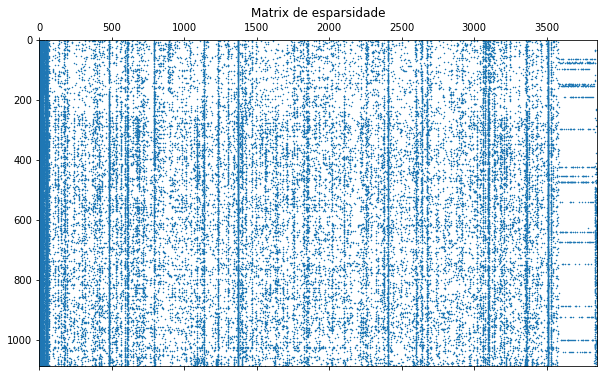

In [79]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.spy(df_exploded.applymap(bool), markersize=0.5)
ax.set_aspect('auto')
plt.title("Matrix de esparsidade")
plt.show()

## Matriz de similaridade

Para o sistema de recomendação, é necessário calcular uma medidade de similaridade entre os produtos do dataset.  
Para este caso, será utilizada a similaridade por cosseno, visto que traz bons resultados para matrizes muito esparsas.  

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(df_exploded[df_exploded.columns[5:]])
cs.shape

(1087, 1087)

In [83]:
# Armazena a matriz e o dataframe em um arquivo
np.save("Similarity Matrix.npy", cs)
df.to_csv("Exploded Dataframe.csv", index=False)

## Teste de recomendação

Como exemplo, vamos selecionar o item nº 821 da lista de produtos e encontrar os 5 produtos mais semelhantes à ele.

In [84]:
id_item_procura = 760
item_procura = df.iloc[id_item_procura]
item_procura

Brand                                                     LAB SERIES
Name                                 Daily Rescue Energizing Essence
Category                                        Masks And Treatments
Rating                                             Sem Classificação
Price                                                       U$ 50.12
Skin Type                           [Combination, Dry, Normal, Oily]
Skin Concerns      [Ageing, Dryness, Dullness, Fine Lines & Wrink...
Formulation                                                       []
Skincare By Age                       [20s, 30s, 40s, 50+, Under 20]
Ingredients        [water, alcohol denat, butylene glycol, polyso...
Function                                                          []
Full Name               LAB SERIES | Daily Rescue Energizing Essence
Name: 760, dtype: object

In [85]:
df[df['Name'].str.contains('The Dewy Skin Cream')]

,Brand,Name,Category,Rating,Price,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Full Name
278,TATCHA,The Dewy Skin Cream,Moisturiser,4.2,U$ 83.53,"[Dry, Normal]","[Ageing, Dryness, Dullness, Uneven Skin Textur...",[Cream],"[20s, 30s, 40s, 50+]","[water, saccharomyces camellia sinensis leaf c...",[],TATCHA | The Dewy Skin Cream
280,TATCHA,The Dewy Skin Cream (Limited Edition) • 75 ml,Moisturiser,4.4,U$ 93.08,"[Dry, Normal]","[Dryness, Dullness, Uneven Skin Texture]",[Cream],"[20s, 30s, 40s, 50+, Under 20]","[water, saccharomyces camellia sinensis leaf c...",[],TATCHA | The Dewy Skin Cream (Limited Edition)...


In [89]:
print(cs[id_item_procura])

[0.34387319 0.28817938 0.41513904 ... 0.24480416 0.31759538 0.30070838]


In [86]:
similar_list = list(enumerate(cs[id_item_procura]))
sorted_similar_list = sorted(similar_list, key=lambda x: x[1], reverse=True)
top_5 = sorted_similar_list[0:5]

top_5_idx, top_5_sim = zip(*top_5)
top_5_idx = list(top_5_idx)
top_5_sim = [round(x,2) for x in top_5_sim]

df_top5 = df.iloc[list(top_5_idx)].copy()
df_top5['Similarity'] = top_5_sim

df_top5

,Brand,Name,Category,Rating,Price,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Full Name,Similarity
760,LAB SERIES,Daily Rescue Energizing Essence,Masks And Treatments,Sem Classificação,U$ 50.12,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Dullness, Fine Lines & Wrink...",[],"[20s, 30s, 40s, 50+, Under 20]","[water, alcohol denat, butylene glycol, polyso...",[],LAB SERIES | Daily Rescue Energizing Essence,1.00
1000,LAB SERIES,Solid Water Essence,Masks And Treatments,5.0,U$ 45.35,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness]",[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, alcohol denat, butylene glycol, polyso...",[],LAB SERIES | Solid Water Essence,0.96
443,LAB SERIES,Pro LS All-In-One Hydrating Gel,Moisturiser,Sem Classificação,U$ 29.83,"[Combination, Dry, Normal, Oily]",[Dryness],[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, butylene glycol, alcohol denat, ammoni...",[],LAB SERIES | Pro LS All-In-One Hydrating Gel,0.63
771,LAB SERIES,Daily Rescue Repair Serum,Masks And Treatments,Sem Classificação,U$ 70.41,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Fine Lines & Wrinkles, Uneve...",[Liquid],"[20s, 30s, 40s, 50+, Under 20]","[water, butylene glycol, bis peg 18 methyl eth...",[],LAB SERIES | Daily Rescue Repair Serum,0.62
627,ESTÉE LAUDER,Perfectionist Pro Intense Brightening Essence ...,Masks And Treatments,4.5,U$ 126.73,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness, Fine Lines & Wrinkles, Pig...","[Liquid, Lotion]","[20s, 30s, 40s, 50+, Under 20]","[water, peg 8, butylene glycol, ascorbyl gluco...",[],ESTÉE LAUDER | Perfectionist Pro Intense Brigh...,0.60


# Testing

In [ ]:
dft = pd.DataFrame({
    'bar': ["1", "", "3"],
    'bar2': [2, 1, 1],
})
dft

,bar,bar2
0,1,2
1,,1
2,3,1
